# Análise de Dados de Imagens de Animais

Este notebook realiza uma análise detalhada de um conjunto de dados de imagens de animais, incluindo a extração de informações, visualização de dados e análise estatística. O objetivo é entender melhor a distribuição das anotações e pontos-chave nas imagens, além de explorar correlações e padrões nos dados.

## Importação de Bibliotecas Necessárias

In [97]:
!pip install pillow numpy matplotlib graphviz -q

In [98]:
import os
import json
import gdown
import random
import zipfile
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageOps
from IPython.display import Image

## Carregamento e Conversão dos Dados

Carregamos o arquivo JSON contendo as anotações e convertemos as informações em DataFrames para facilitar a análise.

In [ ]:
# URLs dos arquivos
url_images = 'https://drive.google.com/uc?id=1Ge9jZppE9pGxqVyNAh6bWh4_ukffWBlF'
url_keypoints = 'https://drive.google.com/uc?id=1bAidtvR3MttetncXz0mfr47vYy7Uf5hm'

# Baixando os arquivos usando gdown
gdown.download(url_images, 'images.zip', quiet=True)  # Baixa o arquivo zip contendo as imagens
gdown.download(url_keypoints, 'keypoints.json', quiet=True)  # Baixa o arquivo JSON contendo os keypoints (pontos-chave)

# Extraindo o arquivo zip
with zipfile.ZipFile('images.zip', 'r') as zip_ref:
    zip_ref.extractall()  # Extrai todos os arquivos do zip para o diretório atual

## Download e Extração dos Arquivos

Primeiro, realizamos o download dos arquivos de imagens e das anotações de pontos-chave.

In [ ]:
# Carregando o arquivo JSON
with open('keypoints.json') as f:
    data = json.load(f)  # Carrega os dados do arquivo JSON para a variável 'data'

# Convertendo os dados para DataFrames do pandas
# Convertendo informações das imagens
images = [{'image_id': int(k), 'file_name': v} for k, v in data['images'].items()]
df_images = pd.DataFrame(images)  # Cria um DataFrame com as informações das imagens

# Convertendo anotações
df_annotations = pd.DataFrame(data['annotations'])  # Cria um DataFrame com as anotações dos keypoints

# Convertendo categorias
df_categories = pd.DataFrame(data['categories'])  # Cria um DataFrame com as categorias dos keypoints

## Inspeção Inicial dos Dados

Visualizamos as primeiras linhas dos DataFrames para entender a estrutura dos dados.



In [3]:
df_images.head()

,image_id,file_name
0,1,2007_000063.jpg
1,2,2007_000175.jpg
2,3,2007_000332.jpg
3,4,2007_000392.jpg
4,5,2007_000464.jpg


In [4]:
df_annotations.head()

,image_id,bbox,keypoints,num_keypoints,category_id
0,1,"[123, 115, 379, 275]","[[193, 216, 1], [160, 217, 1], [174, 261, 1], ...",20,1
1,2,"[25, 34, 419, 271]","[[330, 84, 1], [245, 91, 1], [290, 137, 1], [3...",20,3
2,3,"[54, 50, 285, 262]","[[275, 102, 1], [247, 105, 1], [269, 156, 1], ...",20,4
3,4,"[100, 96, 355, 324]","[[0, 0, 0], [327, 161, 1], [350, 192, 1], [333...",20,4
4,5,"[71, 252, 216, 314]","[[103, 269, 1], [86, 269, 1], [92, 284, 1], [1...",20,5


In [5]:
df_categories.head()

,supercategory,id,name,keypoints,skeleton
0,animal,1,dog,"[left_eye, right_eye, nose, left_ear, right_ea...","[[0, 1], [0, 2], [1, 2], [0, 3], [1, 4], [2, 1..."
1,animal,2,cat,"[left_eye, right_eye, nose, left_ear, right_ea...","[[0, 1], [0, 2], [1, 2], [0, 3], [1, 4], [2, 1..."
2,animal,3,sheep,"[left_eye, right_eye, nose, left_ear, right_ea...","[[0, 1], [0, 2], [1, 2], [0, 3], [1, 4], [2, 1..."
3,animal,4,horse,"[left_eye, right_eye, nose, left_ear, right_ea...","[[0, 1], [0, 2], [1, 2], [0, 3], [1, 4], [2, 1..."
4,animal,5,cow,"[left_eye, right_eye, nose, left_ear, right_ea...","[[0, 1], [0, 2], [1, 2], [0, 3], [1, 4], [2, 1..."


## Verificação de Dados Ausentes

Verificamos se há dados ausentes nos DataFrames.


In [12]:
print(df_images.isnull().sum())

image_id     0
file_name    0
dtype: int64


In [13]:
print(df_annotations.isnull().sum())

image_id         0
bbox             0
keypoints        0
num_keypoints    0
category_id      0
dtype: int64


In [14]:
print(df_categories.isnull().sum())

supercategory    0
id               0
name             0
keypoints        0
skeleton         0
dtype: int64


In [69]:
# Verificando a existência dos arquivos de imagem
# Aplica uma função lambda em cada nome de arquivo na coluna 'file_name' do DataFrame df_images
# A função lambda verifica se o arquivo existe no diretório 'images'
image_files = df_images['file_name'].apply(lambda x: os.path.exists(f'images/{x}'))

# Imprimindo a quantidade de arquivos faltantes
# Conta quantos arquivos não foram encontrados (ou seja, onde a verificação de existência retornou False)
print(f"Missing files: {image_files[~image_files].count()}")

Missing files: 0


## Distribuição das Categorias

Analisamos a distribuição das anotações por categoria.

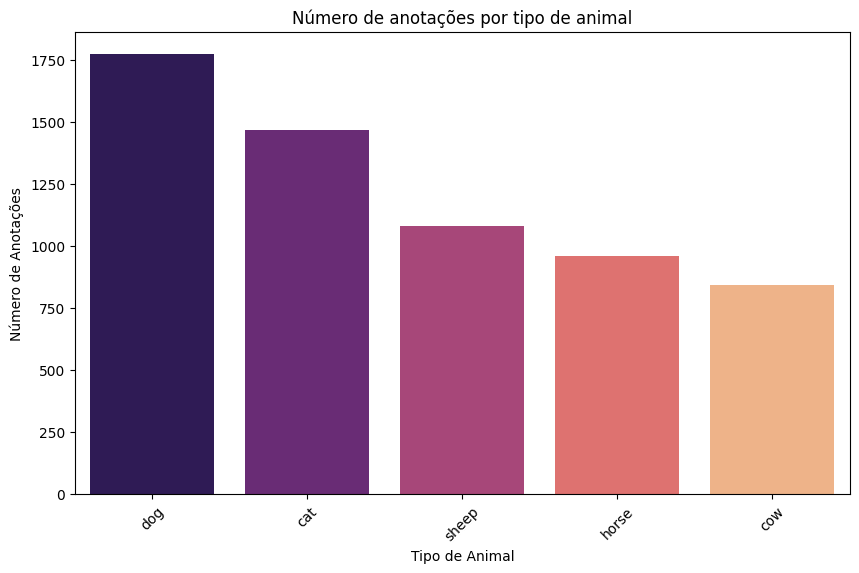

In [71]:
# Contando o número de anotações por categoria
# value_counts() conta a frequência de cada valor na coluna 'category_id' do DataFrame df_annotations
# reset_index() reseta o índice do DataFrame resultante para transformar a série em um DataFrame
category_counts = df_annotations['category_id'].value_counts().reset_index()

# Renomeando as colunas do DataFrame resultante para 'category_id' e 'count'
category_counts.columns = ['category_id', 'count']

# Juntando (merge) os dados de contagem de categorias com o DataFrame de categorias
# left_on='category_id' e right_on='id' especificam as colunas para a junção
category_counts = category_counts.merge(df_categories, left_on='category_id', right_on='id')

# Criando um gráfico de barras para visualizar o número de anotações por tipo de animal
plt.figure(figsize=(10, 6))  # Define o tamanho da figura do gráfico
sns.barplot(data=category_counts, x='name', y='count', hue='name', palette='magma', dodge=False, legend=False)
plt.title('Número de anotações por tipo de animal')  # Título do gráfico
plt.xlabel('Tipo de Animal')  # Rótulo do eixo x
plt.ylabel('Número de Anotações')  # Rótulo do eixo y
plt.xticks(rotation=45)  # Rotaciona os rótulos do eixo x em 45 graus para melhor legibilidade
plt.show()  # Exibe o gráfico

In [72]:
# Verifica se a categoria 'cow' (vaca) está presente no DataFrame df_categories
if 'cow' in df_categories['name'].values:
    # Se a categoria 'cow' estiver presente, obtém o ID correspondente
    cow_id = df_categories[df_categories['name'] == 'cow']['id'].values[0]

    # Filtra as anotações no DataFrame df_annotations para obter apenas as anotações da categoria 'cow'
    cow_annotations = df_annotations[df_annotations['category_id'] == cow_id]

    # Conta o número de imagens únicas que têm anotações da categoria 'cow'
    num_cow_images = cow_annotations['image_id'].nunique()

    # Imprime o número de imagens que contêm a categoria 'cow'
    print(f"Number of images with 'cow' category: {num_cow_images}")
else:
    # Se a categoria 'cow' não estiver presente, imprime uma mensagem informando isso
    print("'cow' category not found.")

Number of images with 'cow' category: 534


## Detalhamento dos Pontos-Chave

Extraímos e visualizamos os detalhes dos pontos-chave.

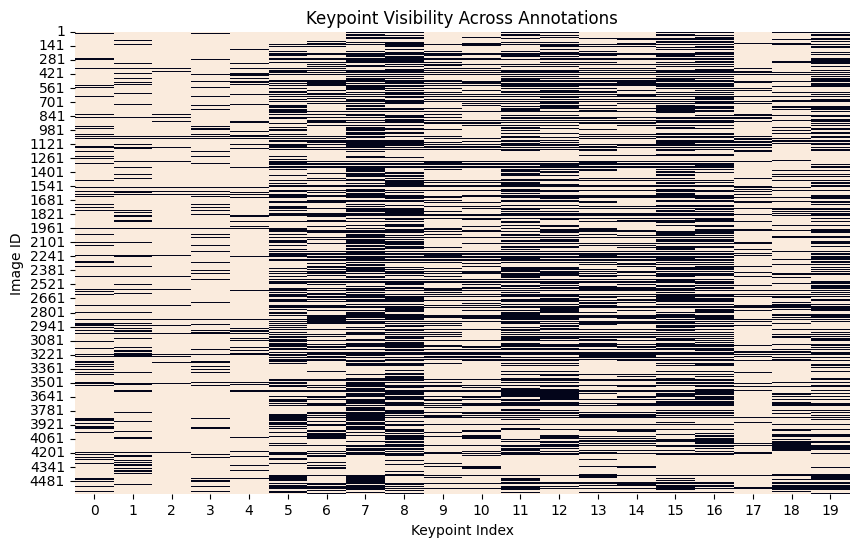

In [73]:
# Função para extrair os keypoints (pontos-chave) de um DataFrame
def extract_keypoints(df):
    # Dicionário para armazenar os dados dos keypoints
    keypoints_data = {
        'image_id': [],
        'kp_index': [],
        'x': [],
        'y': [],
        'visibility': []
    }

    # Itera sobre cada linha do DataFrame
    for index, row in df.iterrows():
        # Itera sobre cada keypoint na lista de keypoints da linha atual
        for i, kp in enumerate(row['keypoints']):
            # Adiciona os dados do keypoint ao dicionário
            keypoints_data['image_id'].append(row['image_id'])
            keypoints_data['kp_index'].append(i)
            keypoints_data['x'].append(kp[0])
            keypoints_data['y'].append(kp[1])
            keypoints_data['visibility'].append(kp[2])

    # Converte o dicionário em um DataFrame e retorna
    return pd.DataFrame(keypoints_data)

# Verifica se a coluna 'keypoints' está presente no DataFrame df_annotations
if 'keypoints' in df_annotations.columns:
    # Extrai os keypoints do DataFrame df_annotations
    df_keypoints = extract_keypoints(df_annotations)

    # Cria uma tabela pivot para visualizar a visibilidade dos keypoints
    # index='image_id' define as linhas como IDs das imagens
    # columns='kp_index' define as colunas como índices dos keypoints
    # values='visibility' define os valores da tabela como a visibilidade dos keypoints
    # aggfunc='max' usa a função máxima para agregar os valores
    kp_visibility = df_keypoints.pivot_table(index='image_id', columns='kp_index', values='visibility', aggfunc='max')

    # Visualiza a completude dos keypoints com um mapa de calor
    plt.figure(figsize=(10, 6))  # Define o tamanho da figura do gráfico
    sns.heatmap(kp_visibility, cbar=False)  # Cria o mapa de calor sem a barra de cores
    plt.title('Keypoint Visibility Across Annotations')  # Título do gráfico
    plt.xlabel('Keypoint Index')  # Rótulo do eixo x
    plt.ylabel('Image ID')  # Rótulo do eixo y
    plt.show()  # Exibe o gráfico


## Visualização de Imagens de Amostra

Visualizamos algumas imagens de amostra com as anotações de bounding boxes.

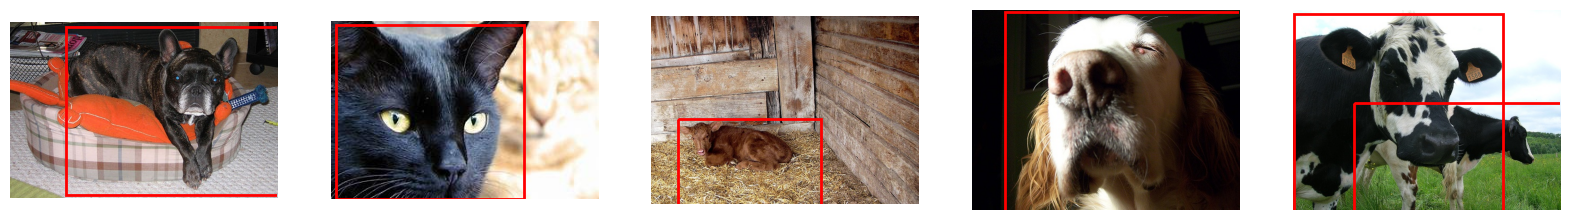

In [75]:
# Função para plotar imagens de amostra com anotações
def plot_sample_images(n=5):
    # Seleciona n imagens aleatórias do DataFrame df_images
    sample_images = df_images.sample(n)

    # Cria uma figura com subplots, 1 linha e n colunas
    fig, axes = plt.subplots(1, n, figsize=(20, 4))

    # Itera sobre cada eixo e linha das imagens amostradas
    for ax, (_, row) in zip(axes, sample_images.iterrows()):
        # Constroi o caminho da imagem
        img_path = 'images/' + row['file_name']

        # Abre a imagem usando PIL
        img = Image.open(img_path)

        # Exibe a imagem no subplot atual
        ax.imshow(img)

        # Remove os eixos para uma visualização mais limpa
        ax.axis('off')

        # Desenha as anotações na imagem
        anns = df_annotations[df_annotations['image_id'] == row['image_id']]
        for _, ann in anns.iterrows():
            if 'bbox' in ann:
                x, y, w, h = ann['bbox']
                # Cria um retângulo em torno da bounding box
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
                # Adiciona o retângulo ao subplot atual
                ax.add_patch(rect)

    # Exibe a figura com as imagens e anotações
    plt.show()

# Chama a função para plotar 5 imagens de amostra
plot_sample_images()


## Análise de Correlação para Bounding Boxes

Calculamos e visualizamos a matriz de correlação para os atributos das bounding boxes.

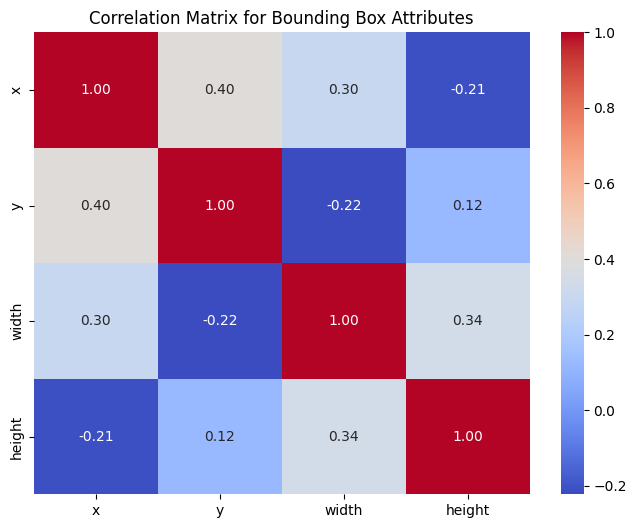

In [76]:
if 'bbox' in df_annotations.columns:
    # Expande a coluna 'bbox' em quatro colunas separadas: 'x', 'y', 'width', 'height'
    bbox_df = df_annotations['bbox'].apply(pd.Series)
    bbox_df.columns = ['x', 'y', 'width', 'height']

    # Calcula a matriz de correlação entre os atributos da bounding box
    correlation_matrix = bbox_df.corr()

    # Configura a figura para o gráfico de calor
    plt.figure(figsize=(8, 6))

    # Cria um mapa de calor da matriz de correlação com anotações e esquema de cores 'coolwarm'
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

    # Define o título do gráfico
    plt.title('Correlation Matrix for Bounding Box Attributes')

    # Exibe o gráfico
    plt.show()


## Análise Avançada de Categorias

Analisamos a área média das anotações para a categoria "cow".

In [77]:
# Verifica se a categoria 'cow' está presente na coluna 'name' do DataFrame df_categories
if 'cow' in df_categories['name'].values:
    # Obtém o ID da categoria 'cow'
    cow_category_id = df_categories.loc[df_categories['name'] == 'cow', 'id'].iloc[0]

    # Filtra as anotações que pertencem à categoria 'cow'
    cow_annotations = df_annotations[df_annotations['category_id'] == cow_category_id].copy()

    # Calcula a área das bounding boxes para as anotações de 'cow'
    cow_annotations['area'] = cow_annotations['bbox'].apply(lambda x: x[2] * x[3])

    # Calcula e imprime a área média das anotações de 'cow'
    print(f"Average area of 'cow' annotations: {cow_annotations['area'].mean()} sq pixels")


Average area of 'cow' annotations: 82256.3135391924 sq pixels


## Distribuição dos Pontos-Chave por Imagem

Visualizamos a distribuição dos pontos-chave visíveis por imagem.

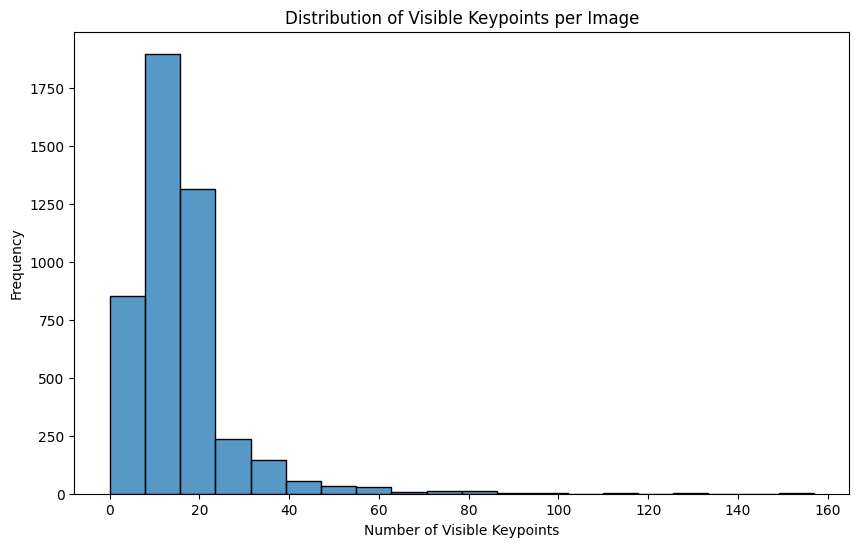

In [78]:
# Cria uma nova coluna 'visible' no DataFrame df_keypoints, indicando se cada keypoint é visível (1) ou não (0)
df_keypoints['visible'] = df_keypoints['visibility'] > 0

# Agrupa os keypoints por 'image_id' e soma o número de keypoints visíveis para cada imagem
visible_kp_per_image = df_keypoints.groupby('image_id')['visible'].sum()

# Configura a figura para o histograma
plt.figure(figsize=(10, 6))

# Cria um histograma da distribuição do número de keypoints visíveis por imagem
sns.histplot(visible_kp_per_image, bins=20, kde=False)

# Define o título do gráfico
plt.title('Distribution of Visible Keypoints per Image')

# Define o rótulo do eixo x
plt.xlabel('Number of Visible Keypoints')

# Define o rótulo do eixo y
plt.ylabel('Frequency')

# Exibe o gráfico
plt.show()


## Verificação de Sobreposição de Bounding Boxes

Verificamos a sobreposição de bounding boxes nas imagens.

In [79]:
def check_overlap(df):
    """
    Verifica se há sobreposição de bounding boxes em cada imagem no DataFrame fornecido.

    Parâmetros:
    df (pd.DataFrame): DataFrame contendo as anotações das imagens, incluindo as bounding boxes e IDs das imagens.

    Retorna:
    list: Lista de IDs de imagens que contêm bounding boxes sobrepostas.
    """
    overlaps = []  # Lista para armazenar os IDs das imagens com bounding boxes sobrepostas
    grouped = df.groupby('image_id')  # Agrupa o DataFrame pelo ID da imagem

    # Itera sobre cada grupo (cada imagem) no DataFrame agrupado
    for name, group in grouped:
        bboxes = group['bbox'].tolist()  # Converte a coluna 'bbox' para uma lista de bounding boxes

        # Verifica sobreposição entre todas as combinações de bounding boxes na imagem
        for i in range(len(bboxes)):
            for j in range(i + 1, len(bboxes)):
                x1, y1, w1, h1 = bboxes[i]  # Coordenadas e dimensões da primeira bounding box
                x2, y2, w2, h2 = bboxes[j]  # Coordenadas e dimensões da segunda bounding box

                # Verifica se há sobreposição entre as duas bounding boxes
                if (x1 < x2 + w2 and x1 + w1 > x2 and y1 < y2 + h2 and y1 + h1 > y2):
                    overlaps.append(name)  # Adiciona o ID da imagem à lista de sobreposições
                    break  # Sai do loop interno ao encontrar a primeira sobreposição

    return overlaps  # Retorna a lista de IDs de imagens com bounding boxes sobrepostas

# Chama a função check_overlap com o DataFrame de anotações
overlapping_images = check_overlap(df_annotations)

# Imprime o número de imagens com bounding boxes sobrepostas
print(f'Number of images with overlapping bounding boxes: {len(set(overlapping_images))}')

Number of images with overlapping bounding boxes: 761


## Visualização de Heatmap dos Pontos-Chave

Criamos um heatmap para visualizar a localização dos pontos-chave.

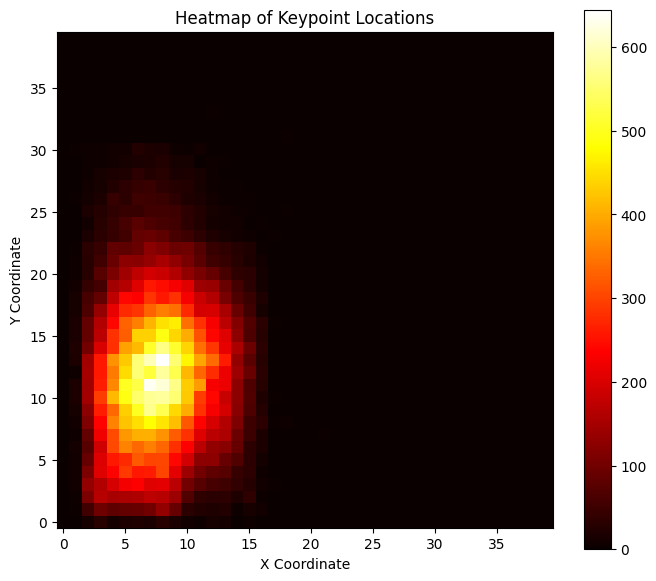

In [81]:
# Cria um histograma bidimensional (2D) dos keypoints visíveis
# df_keypoints[df_keypoints['visibility'] > 0]['x']: Coordenadas X dos keypoints visíveis
# df_keypoints[df_keypoints['visibility'] > 0]['y']: Coordenadas Y dos keypoints visíveis
# bins=40: Número de bins para o histograma em cada dimensão
heatmap, xedges, yedges = np.histogram2d(
    df_keypoints[df_keypoints['visibility'] > 0]['x'],
    df_keypoints[df_keypoints['visibility'] > 0]['y'],
    bins=40
)

# Configura a figura para o heatmap
plt.figure(figsize=(8, 7))

# Plota o heatmap dos keypoints
# heatmap.T: Transpõe o heatmap para alinhar corretamente as coordenadas
# origin='lower': Define a origem do gráfico no canto inferior esquerdo
# cmap='hot': Define o mapa de cores como 'hot' (vermelho para valores altos, amarelo para baixos)
# interpolation='nearest': Define a interpolação como 'nearest' para evitar suavização
plt.imshow(heatmap.T, origin='lower', cmap='hot', interpolation='nearest')

# Define o título do gráfico
plt.title('Heatmap of Keypoint Locations')

# Define o rótulo do eixo X
plt.xlabel('X Coordinate')

# Define o rótulo do eixo Y
plt.ylabel('Y Coordinate')

# Adiciona uma barra de cores ao gráfico para indicar a intensidade dos valores
plt.colorbar()

# Exibe o gráfico
plt.show()

## Análise da Área Média por Categoria

Calculamos a área média das anotações por categoria.

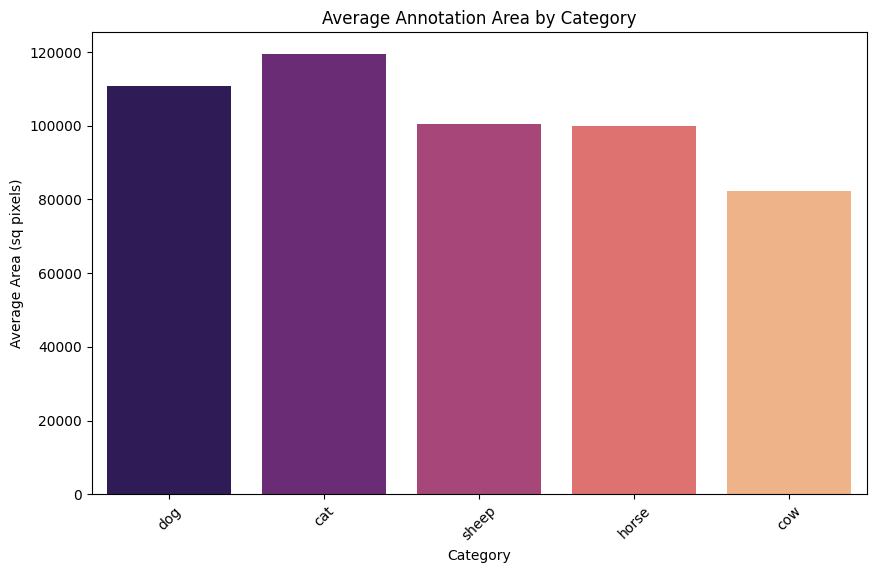

In [82]:
# Calcula a área de cada bounding box e adiciona uma nova coluna 'area' no DataFrame de anotações
# df_annotations['bbox'].apply(lambda x: x[2] * x[3]): Aplica uma função lambda para calcular a área (largura * altura) de cada bounding box
df_annotations['area'] = df_annotations['bbox'].apply(lambda x: x[2] * x[3])

# Agrupa o DataFrame de anotações pela categoria e calcula a média da área das bounding boxes para cada categoria
# .groupby('category_id')['area'].mean(): Agrupa por 'category_id' e calcula a média da coluna 'area'
# .reset_index(): Reseta o índice para transformar o resultado em um DataFrame
average_area_by_category = df_annotations.groupby('category_id')['area'].mean().reset_index()

# Faz a junção do DataFrame resultante com o DataFrame de categorias para adicionar os nomes das categorias
# .merge(df_categories, left_on='category_id', right_on='id'): Faz a junção com base na coluna 'category_id' do primeiro DataFrame e 'id' do segundo
average_area_by_category = average_area_by_category.merge(df_categories, left_on='category_id', right_on='id')

# Configura a figura para o gráfico de barras
plt.figure(figsize=(10, 6))

# Plota um gráfico de barras para a média da área das anotações por categoria
# sns.barplot(data=average_area_by_category, x='name', y='area', hue='name', palette='magma'): Cria o gráfico de barras
# data=average_area_by_category: Define o DataFrame de dados a ser usado
# x='name': Define o eixo X como os nomes das categorias
# y='area': Define o eixo Y como a média da área
# hue='name': Define a cor das barras com base nas categorias
# palette='magma': Define a paleta de cores 'magma'
sns.barplot(data=average_area_by_category, x='name', y='area', hue='name', palette='magma')

# Define o título do gráfico
plt.title('Average Annotation Area by Category')

# Define o rótulo do eixo X
plt.xlabel('Category')

# Define o rótulo do eixo Y
plt.ylabel('Average Area (sq pixels)')

# Rotaciona os rótulos do eixo X para melhor legibilidade
plt.xticks(rotation=45)

# Exibe o gráfico
plt.show()

## Distribuição Espacial dos Centros das Bounding Boxes

Visualizamos a distribuição espacial dos centros das bounding boxes.

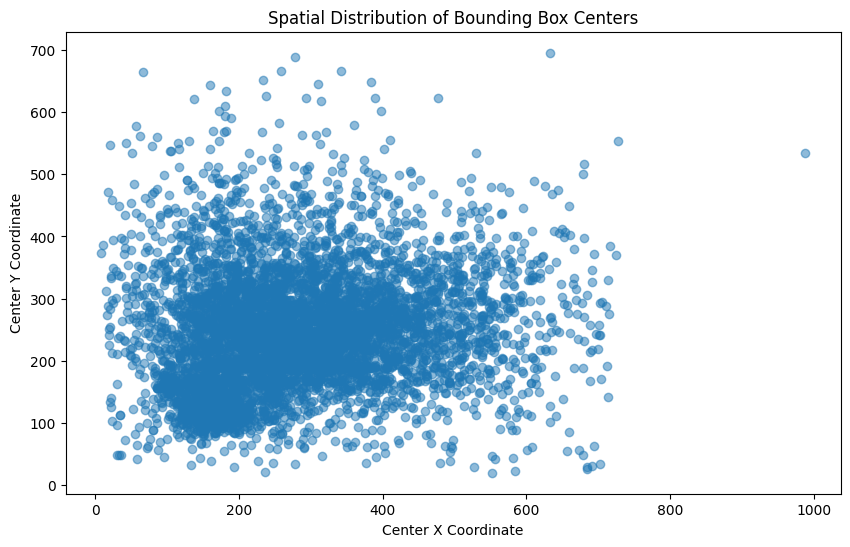

In [85]:
# Calcula a coordenada X do centro de cada bounding box e adiciona uma nova coluna 'center_x' no DataFrame de anotações
# df_annotations['bbox'].apply(lambda x: x[0] + x[2]/2): Aplica uma função lambda para calcular o centro X (coordenada X da borda esquerda + metade da largura) de cada bounding box
df_annotations['center_x'] = df_annotations['bbox'].apply(lambda x: x[0] + x[2]/2)

# Calcula a coordenada Y do centro de cada bounding box e adiciona uma nova coluna 'center_y' no DataFrame de anotações
# df_annotations['bbox'].apply(lambda x: x[1] + x[3]/2): Aplica uma função lambda para calcular o centro Y (coordenada Y da borda superior + metade da altura) de cada bounding box
df_annotations['center_y'] = df_annotations['bbox'].apply(lambda x: x[1] + x[3]/2)

# Configura a figura para o gráfico de dispersão
plt.figure(figsize=(10, 6))

# Plota um gráfico de dispersão para a distribuição espacial dos centros das bounding boxes
# plt.scatter(df_annotations['center_x'], df_annotations['center_y'], alpha=0.5): Cria o gráfico de dispersão
# df_annotations['center_x']: Coordenadas X dos centros das bounding boxes
# df_annotations['center_y']: Coordenadas Y dos centros das bounding boxes
# alpha=0.5: Define a transparência dos pontos para 50%
plt.scatter(df_annotations['center_x'], df_annotations['center_y'], alpha=0.5)

# Define o título do gráfico
plt.title('Spatial Distribution of Bounding Box Centers')

# Define o rótulo do eixo X
plt.xlabel('Center X Coordinate')

# Define o rótulo do eixo Y
plt.ylabel('Center Y Coordinate')

# Exibe o gráfico
plt.show()

## Relação entre Tamanho da Bounding Box e Visibilidade dos Pontos-Chave

Analisamos a relação entre o tamanho das bounding boxes e a visibilidade dos pontos-chave.

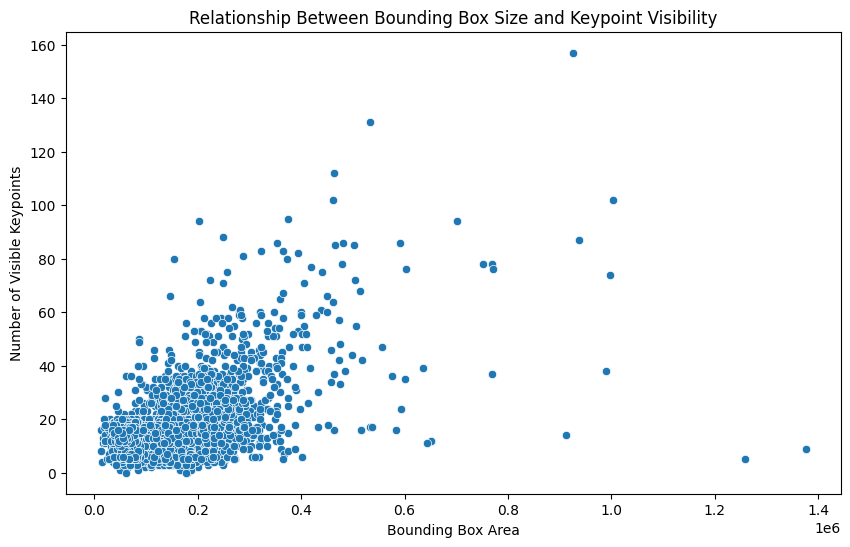

In [86]:
# Agrupa o DataFrame de keypoints pelo 'image_id' e soma a coluna 'visible' para contar o número total de keypoints visíveis por imagem
# .groupby('image_id')['visible'].sum(): Agrupa por 'image_id' e soma a coluna 'visible'
# .reset_index(): Reseta o índice para transformar o resultado em um DataFrame
df_keypoints_summary = df_keypoints.groupby('image_id')['visible'].sum().reset_index()

# Agrupa o DataFrame de anotações pelo 'image_id' e soma a coluna 'area' para calcular a área total das bounding boxes por imagem
# .groupby('image_id')['area'].sum(): Agrupa por 'image_id' e soma a coluna 'area'
# .reset_index(): Reseta o índice para transformar o resultado em um DataFrame
df_bounding_box_sizes = df_annotations.groupby('image_id')['area'].sum().reset_index()

# Faz a junção dos DataFrames de keypoints e de áreas de bounding boxes com base no 'image_id'
# pd.merge(df_keypoints_summary, df_bounding_box_sizes, on='image_id'): Faz a junção dos dois DataFrames com base na coluna 'image_id'
df_merged = pd.merge(df_keypoints_summary, df_bounding_box_sizes, on='image_id')

# Configura a figura para o gráfico de dispersão
plt.figure(figsize=(10, 6))

# Plota um gráfico de dispersão para visualizar a relação entre a área das bounding boxes e o número de keypoints visíveis
# sns.scatterplot(data=df_merged, x='area', y='visible'): Cria o gráfico de dispersão
# data=df_merged: Define o DataFrame de dados a ser usado
# x='area': Define o eixo X como a área total das bounding boxes
# y='visible': Define o eixo Y como o número total de keypoints visíveis
sns.scatterplot(data=df_merged, x='area', y='visible')

# Define o título do gráfico
plt.title('Relationship Between Bounding Box Size and Keypoint Visibility')

# Define o rótulo do eixo X
plt.xlabel('Bounding Box Area')

# Define o rótulo do eixo Y
plt.ylabel('Number of Visible Keypoints')

# Exibe o gráfico
plt.show()

## Diversidade de Anotações por Imagem

Analisamos a diversidade de categorias por imagem.

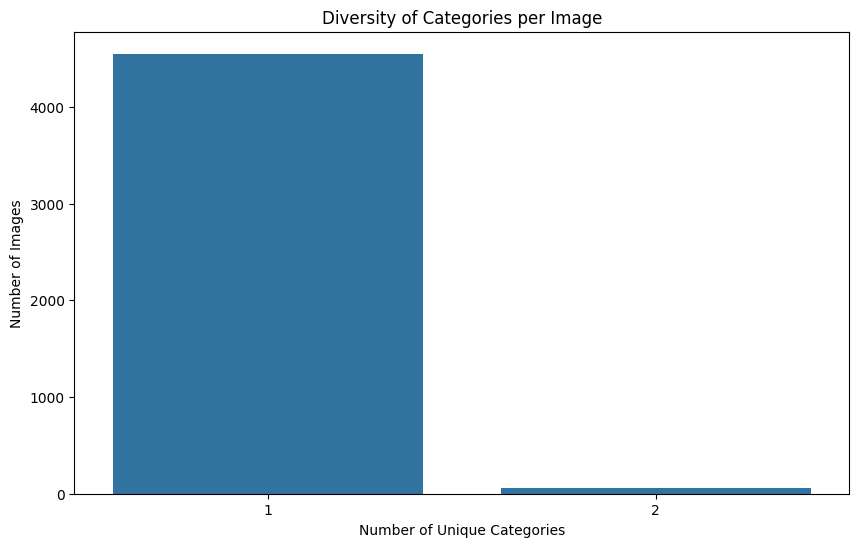

In [87]:
# Agrupa o DataFrame de anotações pelo 'image_id' e calcula o número de categorias únicas ('category_id') por imagem
# .groupby('image_id')['category_id'].nunique(): Agrupa por 'image_id' e calcula o número de categorias únicas
# .reset_index(): Reseta o índice para transformar o resultado em um DataFrame
category_diversity = df_annotations.groupby('image_id')['category_id'].nunique().reset_index()

# Renomeia as colunas do DataFrame resultante para 'image_id' e 'unique_categories'
category_diversity.columns = ['image_id', 'unique_categories']

# Configura a figura para o gráfico de contagem
plt.figure(figsize=(10, 6))

# Plota um gráfico de contagem para visualizar a diversidade de categorias por imagem
# sns.countplot(data=category_diversity, x='unique_categories'): Cria o gráfico de contagem
# data=category_diversity: Define o DataFrame de dados a ser usado
# x='unique_categories': Define o eixo X como o número de categorias únicas por imagem
sns.countplot(data=category_diversity, x='unique_categories')

# Define o título do gráfico
plt.title('Diversity of Categories per Image')

# Define o rótulo do eixo X
plt.xlabel('Number of Unique Categories')

# Define o rótulo do eixo Y
plt.ylabel('Number of Images')

# Exibe o gráfico
plt.show()

## Visualização de Imagens com Anotações

Visualizamos imagens de amostra com as anotações de bounding boxes e pontos-chave.

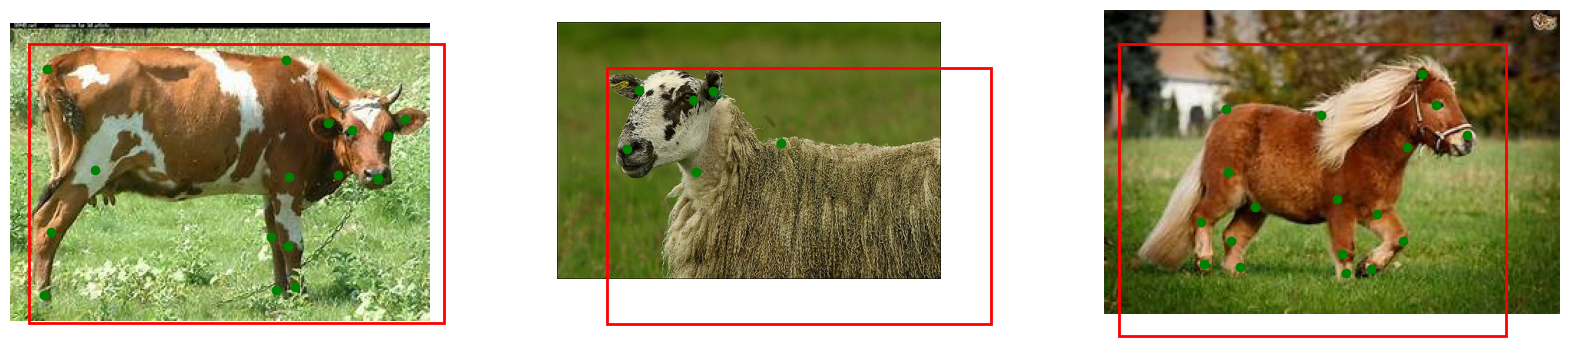

In [88]:
# Definição da função para plotar imagens com anotações
def plot_images_with_annotations(n=3):
    """
    Plota um número especificado de imagens com suas anotações de bounding boxes e keypoints.

    Parâmetros:
    n (int): Número de imagens a serem plotadas. O padrão é 3.
    """
    # Seleciona aleatoriamente n imagens do DataFrame de imagens
    sample_images = df_images.sample(n)

    # Cria uma figura com subplots, um para cada imagem selecionada
    fig, axes = plt.subplots(1, n, figsize=(20, 10))

    # Itera sobre cada subplot e cada linha do DataFrame de imagens amostradas
    for ax, (_, row) in zip(axes, sample_images.iterrows()):
        # Constrói o caminho para a imagem
        img_path = 'images/' + row['file_name']

        # Abre a imagem usando PIL
        img = Image.open(img_path)

        # Exibe a imagem no subplot atual
        ax.imshow(img)

        # Remove os eixos para uma visualização mais limpa
        ax.axis('off')

        # Seleciona as anotações que correspondem à imagem atual
        annotations = df_annotations[df_annotations['image_id'] == row['image_id']]

        # Itera sobre cada anotação
        for _, ann in annotations.iterrows():
            # Extrai a bounding box da anotação
            x, y, w, h = ann['bbox']

            # Cria um retângulo para a bounding box
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')

            # Adiciona o retângulo ao subplot
            ax.add_patch(rect)

            # Extrai e formata os keypoints da anotação
            keypoints = np.array(ann['keypoints']).reshape(-1, 3)

            # Itera sobre cada keypoint
            for kp in keypoints:
                # Se o keypoint é visível (indicado pelo terceiro valor maior que 0)
                if kp[2] > 0:
                    # Plota o keypoint como um ponto verde
                    ax.plot(kp[0], kp[1], 'go')

    # Exibe a figura com as imagens e anotações
    plt.show()

# Chama a função para plotar as imagens com anotações
plot_images_with_annotations()

## Correlação entre Diferentes Atributos Numéricos

Calculamos e visualizamos a matriz de correlação entre diferentes atributos numéricos do conjunto de dados.

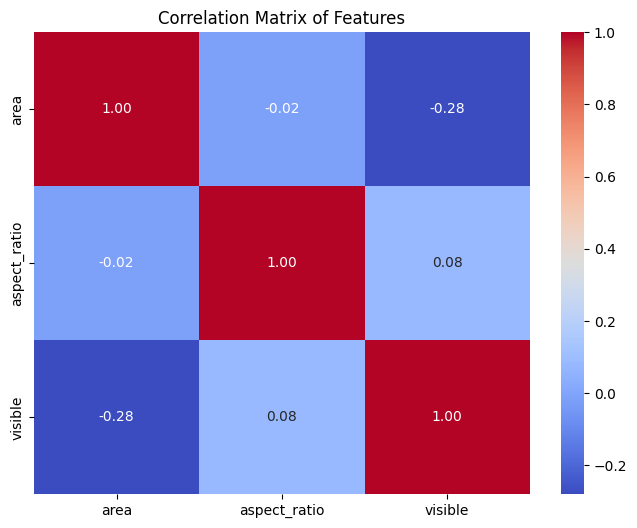

In [89]:
# Calcula a razão de aspecto para cada bounding box e adiciona uma nova coluna ao DataFrame de anotações
# .apply(lambda x: x[2] / x[3]): Aplica uma função lambda que calcula a razão de aspecto (largura/altura) da bounding box
df_annotations['aspect_ratio'] = df_annotations['bbox'].apply(lambda x: x[2] / x[3])

# Agrupa o DataFrame de keypoints pelo 'image_id' e soma os valores da coluna 'visible'
# .groupby('image_id')['visible'].sum().reset_index(): Agrupa por 'image_id' e soma os valores da coluna 'visible', depois reseta o índice
# .merge(..., on='image_id', how='left'): Faz um merge (junção) com o DataFrame de anotações usando 'image_id' como chave, mantendo todas as linhas de df_annotations
df_annotations_keypoints = df_annotations.merge(
    df_keypoints.groupby('image_id')['visible'].sum().reset_index(),
    on='image_id',
    how='left'
)

# Calcula a matriz de correlação para as colunas 'area', 'aspect_ratio' e 'visible'
# .corr(): Calcula a matriz de correlação
corr_matrix = df_annotations_keypoints[['area', 'aspect_ratio', 'visible']].corr()

# Configura a figura para o heatmap
plt.figure(figsize=(8, 6))

# Plota um heatmap da matriz de correlação
# sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f"): Cria o heatmap
# corr_matrix: Define a matriz de correlação a ser plotada
# annot=True: Adiciona os valores da correlação nas células do heatmap
# cmap='coolwarm': Define o esquema de cores do heatmap
# fmt=".2f": Formata os valores da correlação com duas casas decimais
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Define o título do heatmap
plt.title('Correlation Matrix of Features')

# Exibe o heatmap
plt.show()

## Frequência das Categorias por Tamanho da Imagem

Analisamos a frequência das categorias por tamanho da imagem.

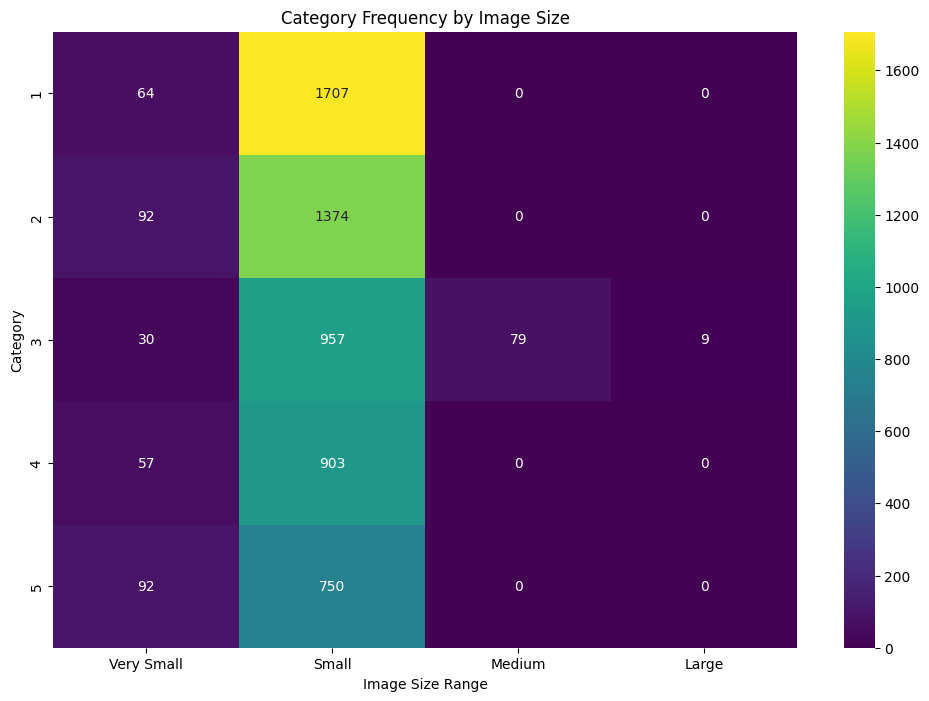

In [90]:
# Função para obter as dimensões da imagem (largura e altura)
def get_image_dimensions(file_name):
    """
    Obtém as dimensões (largura e altura) de uma imagem.

    Parâmetros:
    file_name (str): Nome do arquivo da imagem.

    Retorna:
    tuple: Largura e altura da imagem. Retorna (None, None) em caso de erro.
    """
    try:
        # Abre a imagem e obtém suas dimensões
        with Image.open(os.path.join('images', file_name)) as img:
            return img.width, img.height
    except IOError:
        # Retorna (None, None) se ocorrer um erro ao abrir a imagem
        return None, None

# Definição dos intervalos de tamanhos de imagem (em pixels quadrados) e seus rótulos correspondentes
size_bins = [0, 250*250, 500*500, 750*750, 1000*1000]
labels = ['Very Small', 'Small', 'Medium', 'Large']

# Calcula o tamanho da imagem (área) e adiciona uma nova coluna ao DataFrame de imagens
df_images['image_size'] = df_images['height'] * df_images['width']

# Faz um merge (junção) do DataFrame de anotações com o DataFrame de imagens, incluindo a coluna 'image_size'
df_merged_with_sizes = df_annotations.merge(df_images[['image_id', 'image_size']], on='image_id')

# Classifica as imagens em intervalos de tamanhos definidos e adiciona uma nova coluna 'size_range'
df_merged_with_sizes['size_range'] = pd.cut(df_merged_with_sizes['image_size'], bins=size_bins, labels=labels)

# Agrupa os dados por 'category_id' e 'size_range', contando a frequência de cada combinação
category_size_distribution = df_merged_with_sizes.groupby(['category_id', 'size_range']).size().unstack().fillna(0)

# Configura a figura para o heatmap
plt.figure(figsize=(12, 8))

# Plota um heatmap da distribuição de frequência das categorias por intervalo de tamanho de imagem
# sns.heatmap(category_size_distribution, annot=True, cmap='viridis', fmt=".0f"): Cria o heatmap
# category_size_distribution: Define a matriz de distribuição de frequência a ser plotada
# annot=True: Adiciona os valores da frequência nas células do heatmap
# cmap='viridis': Define o esquema de cores do heatmap
# fmt=".0f": Formata os valores da frequência como inteiros
sns.heatmap(category_size_distribution, annot=True, cmap='viridis', fmt=".0f")

# Define o título do heatmap
plt.title('Category Frequency by Image Size')

# Define o rótulo do eixo X
plt.xlabel('Image Size Range')

# Define o rótulo do eixo Y
plt.ylabel('Category')

# Exibe o heatmap
plt.show()

# Filtragem do Conjunto de Dados para Imagens de Bovinos

Filtramos o conjunto de dados para obter apenas as imagens que contêm bovinos e processamos essas imagens.

In [91]:
# Filtra o ID da categoria 'cow' (vaca) no DataFrame de categorias
cow_id = df_categories[df_categories['name'] == 'cow']['id'].values[0]

# Filtra as anotações que correspondem à categoria 'cow'
cow_annotations = df_annotations[df_annotations['category_id'] == cow_id]

# Obtém os IDs únicos das imagens que contêm anotações da categoria 'cow'
cow_image_ids = cow_annotations['image_id'].unique()

# Filtra o DataFrame de imagens para incluir apenas as imagens que contêm a categoria 'cow'
df_cow_images = df_images[df_images['image_id'].isin(cow_image_ids)]

# Imprime o número de imagens que contêm a categoria 'cow'
print(f"Number of cow images: {len(df_cow_images)}")

Number of cow images: 534


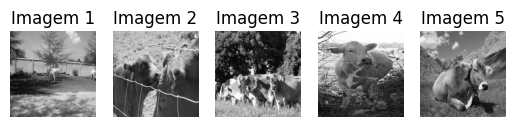

In [92]:
# Função para processar uma imagem
def process_image(image_path):
    """
    Processa uma imagem realizando as seguintes etapas:
    1. Abre a imagem.
    2. Converte a imagem para escala de cinza.
    3. Redimensiona a imagem para 256x256 pixels.
    4. Normaliza os valores dos pixels para o intervalo [0, 1].

    Parâmetros:
    image_path (str): Caminho do arquivo da imagem.

    Retorna:
    np.array: Imagem processada normalizada.
    """
    # Abre a imagem
    img = Image.open(image_path)

    # Converte a imagem para escala de cinza
    img_gray = ImageOps.grayscale(img)

    # Redimensiona a imagem para 256x256 pixels
    img_resized = img_gray.resize((256, 256))

    # Normaliza os valores dos pixels para o intervalo [0, 1]
    img_normalized = np.array(img_resized) / 255.0

    return img_normalized

# Seleciona aleatoriamente 5 caminhos de imagens da categoria 'cow'
random_image_paths = df_cow_images.sample(n=5)['file_name'].tolist()

# Itera sobre os caminhos das imagens selecionadas aleatoriamente
for i, image_name in enumerate(random_image_paths):
    # Constrói o caminho completo da imagem
    image_path = 'images/' + image_name

    # Processa a imagem usando a função definida
    processed_image = process_image(image_path)

    # Plota a imagem processada
    plt.subplot(1, 5, i + 1)
    plt.imshow(processed_image, cmap='gray')
    plt.title(f'Imagem {i + 1}')
    plt.axis('off')

# Exibe todas as imagens processadas
plt.show()

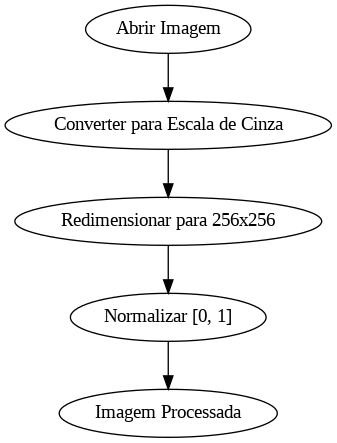

In [99]:
# Cria um novo gráfico
dot = graphviz.Digraph(comment='Processo de Imagem')

# Adiciona os nós do diagrama
dot.node('A', 'Abrir Imagem')
dot.node('B', 'Converter para Escala de Cinza')
dot.node('C', 'Redimensionar para 256x256')
dot.node('D', 'Normalizar [0, 1]')
dot.node('E', 'Imagem Processada')

# Adiciona as arestas (conexões) entre os nós
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')

# Renderiza o diagrama e salva em um arquivo
dot.render('diagrama', format='png')

# Exibe o diagrama
Image(filename='diagrama.png')


# Resultados Finais do Processamento

## Distribuição das Áreas das Anotações

Visualizamos a distribuição das áreas das anotações de bovinos.

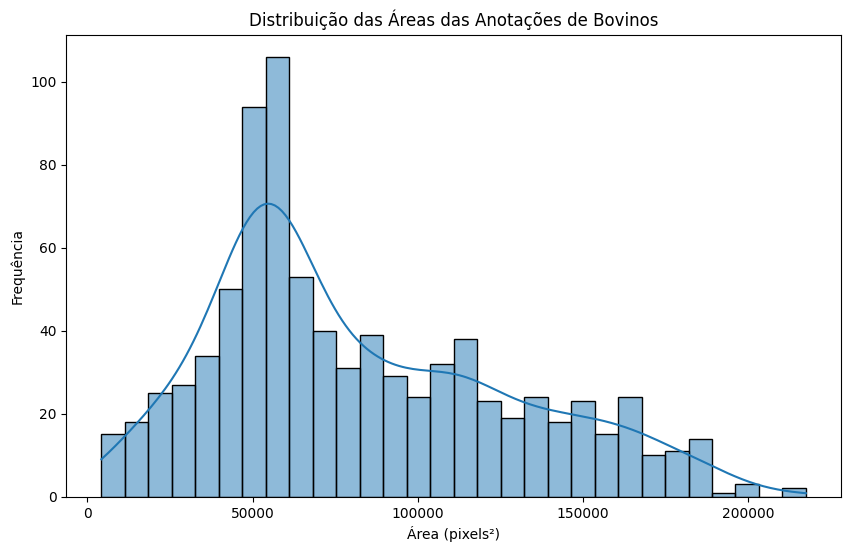

In [93]:
# Calcula a área de cada anotação de bovino e adiciona como uma nova coluna 'area' no DataFrame cow_annotations
cow_annotations.loc[:, 'area'] = cow_annotations['bbox'].apply(lambda x: x[2] * x[3])

# Configura a figura para o gráfico de distribuição
plt.figure(figsize=(10, 6))

# Plota um histograma da distribuição das áreas das anotações de bovinos com uma linha de densidade (KDE)
sns.histplot(cow_annotations['area'], bins=30, kde=True)

# Adiciona o título ao gráfico
plt.title('Distribuição das Áreas das Anotações de Bovinos')

# Adiciona o rótulo ao eixo X
plt.xlabel('Área (pixels²)')

# Adiciona o rótulo ao eixo Y
plt.ylabel('Frequência')

# Exibe o gráfico
plt.show()

## Distribuição dos Pontos-Chave Visíveis

Visualizamos a distribuição dos pontos-chave visíveis por imagem de bovino.

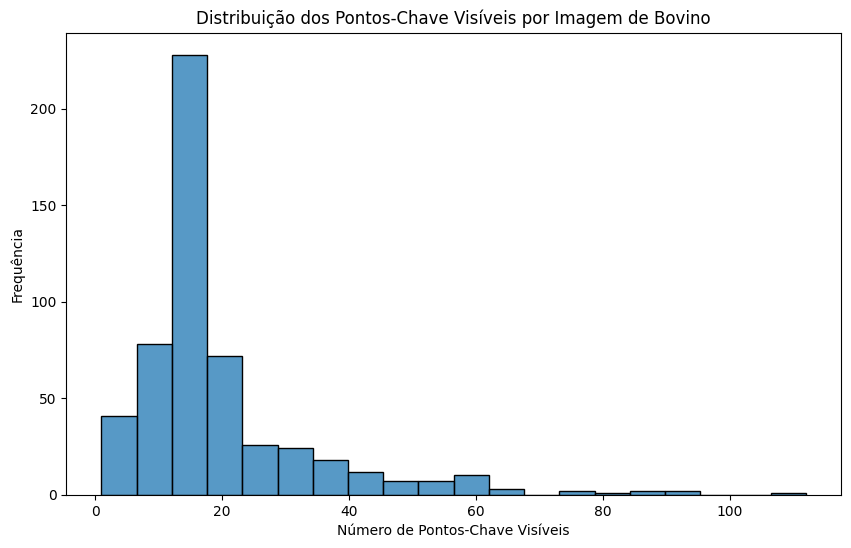

In [94]:
# Filtra os pontos-chave (keypoints) para incluir apenas aqueles que pertencem às imagens de bovinos
cow_keypoints = df_keypoints[df_keypoints['image_id'].isin(cow_image_ids)]

# Agrupa os pontos-chave por 'image_id' e soma o número de pontos-chave visíveis para cada imagem
visible_kp_per_cow_image = cow_keypoints.groupby('image_id')['visible'].sum()

# Configura a figura para o gráfico de distribuição
plt.figure(figsize=(10, 6))

# Plota um histograma da distribuição do número de pontos-chave visíveis por imagem de bovino
sns.histplot(visible_kp_per_cow_image, bins=20, kde=False)

# Adiciona o título ao gráfico
plt.title('Distribuição dos Pontos-Chave Visíveis por Imagem de Bovino')

# Adiciona o rótulo ao eixo X
plt.xlabel('Número de Pontos-Chave Visíveis')

# Adiciona o rótulo ao eixo Y
plt.ylabel('Frequência')

# Exibe o gráfico
plt.show()

## Tabela Resumida dos Resultados

Criamos uma tabela resumida dos resultados para imagens de bovinos.

In [96]:
# Agrupa as anotações de bovinos por 'image_id' e calcula a média da área e o número de anotações por imagem
cow_summary = cow_annotations.groupby('image_id').agg({
    'area': 'mean',  # Calcula a média da área das anotações
    'image_id': 'size'  # Conta o número de anotações por imagem
}).rename(columns={'image_id': 'num_annotations'}).reset_index()  # Renomeia a coluna 'image_id' para 'num_annotations' e reseta o índice

# Mescla o resumo das anotações com a contagem de pontos-chave visíveis por imagem
cow_summary = cow_summary.merge(visible_kp_per_cow_image.reset_index(), on='image_id')

# Renomeia as colunas para nomes mais descritivos
cow_summary.columns = ['Image ID', 'Average Area', 'Number of Annotations', 'Visible Keypoints']

# Exibe as primeiras linhas do DataFrame resultante
cow_summary.head()

,Image ID,Average Area,Number of Annotations,Visible Keypoints
0,5,69459.500000,2,20
1,6,153306.000000,1,5
2,7,203000.000000,1,14
3,16,88894.000000,1,18
4,18,75031.333333,6,66
